# Coffea-Casa Benchmark Example 8

In [1]:
import numpy as np
%matplotlib inline
from coffea import hist
import coffea.processor as processor
import awkward as ak
from coffea.nanoevents import schemas

In [2]:
# This program plots the transverse mass of MET and a third lepton, where the third lepton is associated with a lepton pair
# that has the same flavor, opposite charge, and closest mass to 91.2.

import math

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "MET and Third Lepton")
        muon_axis = hist.Bin("massT", "Transverse Mass", 50, 15, 250)
        
        self._accumulator = processor.dict_accumulator({
            'massT': hist.Hist("Counts", dataset_axis, muon_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata["dataset"]
        
        # Keep track of muons and electrons by tagging them 0/1.
        muons = ak.with_field(events.Muon, 0, 'flavor')
        electrons = ak.with_field(events.Electron, 1, 'flavor')
        MET = events.MET
        
        output['cutflow']['all events'] += ak.size(events.MET, axis=0)
        
        # A few reasonable muon and electron selection cuts
        muons = muons[(muons.pt > 10) & (np.abs(muons.eta) < 2.4)]
        electrons = electrons[(electrons.pt > 10) & (np.abs(electrons.eta) < 2.5)]
        
        output['cutflow']['all muons'] += ak.sum(ak.count(muons, axis=1))
        output['cutflow']['all electrons'] += ak.sum(ak.count(electrons, axis=1))

        # Stack muons and electrons into a single array.
        leptons = ak.with_name(ak.concatenate([muons, electrons], axis=1), 'PtEtaPhiMCandidate')
        
        # Filter out events with less than 3 leptons.
        trileptons = leptons[ak.num(leptons, axis=1) >= 3]
        output['cutflow']['trileptons'] += ak.sum(ak.num(trileptons, axis=1))
        
        # Generate the indices of every pair; indices because we'll be removing these elements later.
        lepton_pairs = ak.argcombinations(trileptons, 2, fields=['i0', 'i1'])
        
        # Select pairs that are SFOS.
        SFOS_pairs = lepton_pairs[(trileptons[lepton_pairs['i0']].flavor == trileptons[lepton_pairs['i1']].flavor) & (trileptons[lepton_pairs['i0']].charge != trileptons[lepton_pairs['i1']].charge)]
        
        # Find the pair with mass closest to Z.
        closest_pairs = SFOS_pairs[ak.local_index(SFOS_pairs) == ak.argmin(np.abs((trileptons[SFOS_pairs['i0']] + trileptons[SFOS_pairs['i1']]).mass - 91.2), axis=1)]
        
        # Make trileptons and closest_pairs have same shape. First, fill nones with empty arrays. Then filter out events that don't meet the pair requirement.
        closest_pairs = ak.fill_none(closest_pairs, [], axis=0)
        closest_pairs = closest_pairs[ak.num(closest_pairs) > 0]
        trileptons = trileptons[ak.num(closest_pairs) > 0]
        MET = MET[ak.num(closest_pairs) > 0]
        
        # Remove elements of the closest pairs from leptons, because we want the pt of the third lepton.
        trileptons_no_pair = trileptons[(ak.local_index(trileptons) != ak.flatten(closest_pairs.i0)) & (ak.local_index(trileptons) != ak.flatten(closest_pairs.i1))]
        
        # Find the highest-pt lepton out of the ones that remain.
        leading_lepton = trileptons_no_pair[ak.argmax(trileptons_no_pair.pt, axis=1)]
        output['cutflow']['number of final leading leptons'] += ak.sum(ak.num(trileptons_no_pair, axis=1))
        
        # Cross MET with the leading lepton.
        met_plus_lep = ak.cartesian({'i0': MET, 'i1': leading_lepton})
        
        # Do some math to get what we want.
        dphi_met_lep = (met_plus_lep.i0.phi - met_plus_lep.i1.phi + math.pi) % (2*math.pi) - math.pi
        mt_lep = np.sqrt(2.0*met_plus_lep.i0.pt*met_plus_lep.i1.pt*(1.0-np.cos(dphi_met_lep)))
        
        output['massT'].fill(dataset=dataset, massT=ak.flatten(mt_lep))
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
from dask.distributed import Client

client = Client("tls://localhost:8786")

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [4]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

executor = processor.DaskExecutor(client=client)

run = processor.Runner(executor=executor,
                        schema=schemas.NanoAODSchema,
                        savemetrics=True
                      )

output, metrics = run(fileset, "Events", processor_instance=Processor())

metrics

{'bytesread': 9982563224,
 'columns': {'Electron_charge',
  'Electron_cutBasedId',
  'Electron_dxy',
  'Electron_dxyErr',
  'Electron_dz',
  'Electron_dzErr',
  'Electron_eta',
  'Electron_genPartIdx',
  'Electron_jetIdx',
  'Electron_mass',
  'Electron_pfId',
  'Electron_pfRelIso03_all',
  'Electron_phi',
  'Electron_pt',
  'MET_CovXX',
  'MET_CovXY',
  'MET_CovYY',
  'MET_phi',
  'MET_pt',
  'MET_significance',
  'MET_sumet',
  'Muon_charge',
  'Muon_dxy',
  'Muon_dxyErr',
  'Muon_dz',
  'Muon_dzErr',
  'Muon_eta',
  'Muon_genPartIdx',
  'Muon_jetIdx',
  'Muon_mass',
  'Muon_pfRelIso03_all',
  'Muon_pfRelIso04_all',
  'Muon_phi',
  'Muon_pt',
  'Muon_softId',
  'Muon_tightId',
  'nElectron',
  'nJet',
  'nMuon'},
 'entries': 53446198,
 'processtime': 8658.274055480957,
 'chunks': 534}

<AxesSubplot:xlabel='Transverse Mass', ylabel='Counts'>

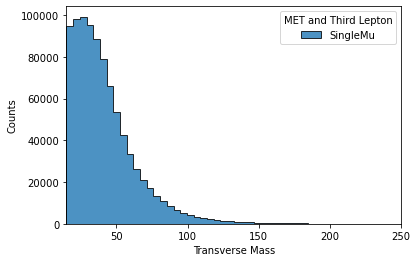

In [5]:
hist.plot1d(output['massT'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [6]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
all muons 991421725
all electrons 87391040
trileptons 5043516
number of final leading leptons 1227755
